# Single-Cell RNA-seq のデータをPythonで解析してみる
## その１　教師なし学習
scRNA-seqデータのPythonによる解析を通して、scRNA-seq解析プラットフォームの中で起きている計算への理解を深める。  
また、以下で紹介する手法は、シングルセルに限らず様々な生物学実験で生成される「テーブル形式」のデータに適用できる。  
自分のフィールドで扱うテーブルに適用した場合にどんな結果や解釈が得られるか、想像しながら実行することを勧める。

<font color="Red">※注意: scRNA-seqデータの（標準的な）解析をやる場合は、Seurat (R) や Scanpy (Python)など、
ちゃんとテストとメンテナンスがされているプラットフォームで解析すること。  
車輪の再発明は避けるべきだし、論文でメソッド書くとき引用も楽になる。  
またscRNA-seq解析に特有ないくつかの解析技術（Dropout imputation, Batch effect correctionなどの前処理、Pseudotime解析、Data integration、Velocyto解析などの発展的な内容）も重要だがここでは扱わない。  
以下はあくまで、シングルセルを主戦場としない研究者にも適用可能な、一般的なテーブルデータを解析するひとつの例として参考にしてください。
</font>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.dpi']= 300
sns.set(style='whitegrid')

print(np.__version__)
print(pd.__version__)
print(matplotlib.__version__)
print(sns.__version__)

1.16.2
0.23.4
3.0.3
0.9.0


# データの読み込み・データフレームの整形

Cell Ranger 3.1.0解析済みのデータは10x Genomicsの [ここのデータ](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.1.0/5k_pbmc_protein_v3) からダウンロード。

5k Peripheral blood mononuclear cells (PBMCs) from a healthy donor with cell surface proteins (v3 chemistry) 

5,247 cells detected

以下のURLからダウンロードし、解凍した。（事前に実行済みなので↓のセルは実行しないでOK）

In [2]:
"""
%%bash
wget http://cf.10xgenomics.com/samples/cell-exp/3.1.0/5k_pbmc_protein_v3/5k_pbmc_protein_v3_filtered_feature_bc_matrix.tar.gz -O 5k_pbmc_protein_v3_filtered_feature_bc_matrix.tar.gz
tar -xzvf 5k_pbmc_protein_v3_filtered_feature_bc_matrix.tar.gz
gunzip filtered_feature_bc_matrix/*.gz
"""

'\n%%bash\nwget http://cf.10xgenomics.com/samples/cell-exp/3.1.0/5k_pbmc_protein_v3/5k_pbmc_protein_v3_filtered_feature_bc_matrix.tar.gz -O 5k_pbmc_protein_v3_filtered_feature_bc_matrix.tar.gz\ntar -xzvf 5k_pbmc_protein_v3_filtered_feature_bc_matrix.tar.gz\ngunzip filtered_feature_bc_matrix/*.gz\n'

Cell Rangerの一次解析後データは Matrix Market フォーマットと呼ばれる疎行列の表現形式で格納されている。  
なので、scipyのmatrix Marketフォーマットを読み込む関数で行列をロードする。

※メモリ4GBではきつかった。フルのデータを解析するのは無理。ここでは、適当に半分の細胞数にダウンサンプリングしたデータを扱う。  
メモリに余裕があって、フルの結果を見たい場合は、matrix.mtx.gz を読み込む。合わせて、barcodes.tsvも。

In [3]:
import os
import scipy.io
import scipy.sparse
print(scipy.__version__)

datadir = './data_sc1/filtered_feature_bc_matrix'

genes = pd.read_csv(os.path.join(datadir, 'features.tsv'), sep='\t', index_col=0, names=['Symbol', 'Feature'])
cells = pd.read_csv(os.path.join(datadir, 'barcodes_downsampled.tsv'), names=['Barcode'])
arr = scipy.io.mmread(os.path.join(datadir, 'matrix_downsampled.mtx.gz'))

1.3.0


In [4]:
arr = np.array(scipy.sparse.csr_matrix.todense(arr))
print(arr.shape)

(33570, 2623)


行列データ、遺伝子情報、細胞バーコードの情報を統合してひとつのデータフレームにする。  
ついでに、遺伝子発現以外の情報（抗体のデータ）や、すべての細胞で発現量ゼロの遺伝子の情報を削除しておく。

In [5]:
df = pd.DataFrame(arr, index=genes.index, columns=cells['Barcode'])
# 遺伝子発現以外の行（Antibody Capture）を削除
# inplace ... メモリ節約
df.drop(df.index[~df.index.str.startswith('ENSG')], inplace=True)
# すべてのcellで発現量ゼロの遺伝子を削除
df.drop(df.index[df.values.sum(axis=1) == 0.0], inplace=True)
print('Total', len(df), 'genes')

Total 19443 genes


データフレームの情報をざっくりと確認してみる。

In [6]:
print(len(df), 'genes,', len(df.columns), 'cells')
# cellごと、割り当てられたリードの総和
# axis=0で、縦方向に総和をとる。つまりサンプルごとの総リード数。
nreads = df.values.sum(axis=0)
# cellごと、わずかにでも発現している遺伝子の数
# > 0.0 の部分で、データフレームの各要素について論理値{True, False}になる
# => astype(int)とすると{True, False}が{1, 0}に変換される。
# => その総和をとることで「正の値をとっていた要素数」が計算できる
ngenes = (df.values > 0.0).astype(int).sum(axis=0)
print('Stats for assigned reads: max=', np.max(nreads), 'min=', np.min(nreads), 'average={:.2f}'.format(np.average(nreads)))
print('Stats for detected genes: max=', np.max(ngenes), 'min=', np.min(ngenes), 'average={:.2f}'.format(np.average(ngenes)))

19443 genes, 2623 cells
Stats for assigned reads: max= 47394 min= 501 average=6177.70
Stats for detected genes: max= 6948 min= 62 average=1771.48


# データの前処理

参考：[Seuratのチュートリアル](https://satijalab.org/seurat/v3.1/pbmc3k_tutorial.html)  
まずは、低クオリティcellの評価指標のひとつである、ミトコンドリア遺伝子の発現割合を計算してみる。

In [7]:
display(genes[ genes['Symbol'].str.startswith('MT-') ])
# Python標準の文字列処理関数のいくつかは、Pandasのstrアクセサでseries全体に適用できる
# ここでは遺伝子名が「MT-」からはじまる（startswith関数）遺伝子IDを抽出
mito_IDs = genes[ genes['Symbol'].str.startswith('MT-') ].index
# cellごと、mito_IDsの遺伝子の発現割合（%）を計算
percent_mito = 100.0 * df.loc[mito_IDs, :].values.sum(axis=0) / df.values.sum(axis=0)

,Symbol,Feature
ENSG00000198888,MT-ND1,Gene Expression
ENSG00000198763,MT-ND2,Gene Expression
ENSG00000198804,MT-CO1,Gene Expression
ENSG00000198712,MT-CO2,Gene Expression
ENSG00000228253,MT-ATP8,Gene Expression
ENSG00000198899,MT-ATP6,Gene Expression
ENSG00000198938,MT-CO3,Gene Expression
ENSG00000198840,MT-ND3,Gene Expression
ENSG00000212907,MT-ND4L,Gene Expression
ENSG00000198886,MT-ND4,Gene Expression


cellごとの総リード数（nreads）、総発現遺伝子数（ngenes）、ミトコンドリア遺伝子発現割合（percent_mito）
の分布をヴァイオリンプロットで可視化してみる。

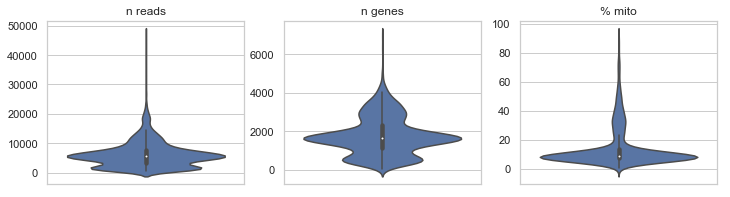

In [8]:
fig = plt.figure(figsize=(12,3))
# １行３列のプロットをax1, ax2, ax3と定義
ax1 = plt.subplot(1, 3, 1)
sns.violinplot(x=nreads, orient='v', ax=ax1).set_title('n reads')
ax2 = plt.subplot(1, 3, 2)
sns.violinplot(x=ngenes, orient='v', ax=ax2).set_title('n genes')
ax3 = plt.subplot(1, 3, 3)
sns.violinplot(x=percent_mito, orient='v', ax=ax3).set_title('% mito')
plt.show()

とりあえず基準として、検出遺伝子数200以上5,000未満のcell, かつ、ミトコンドリア遺伝子発現割合15%未満のcellを抽出することにする。  
それぞれの関係を scatterplot で確認してみる。同時に閾値の外にどの程度のcellがあるのかを見てみる。

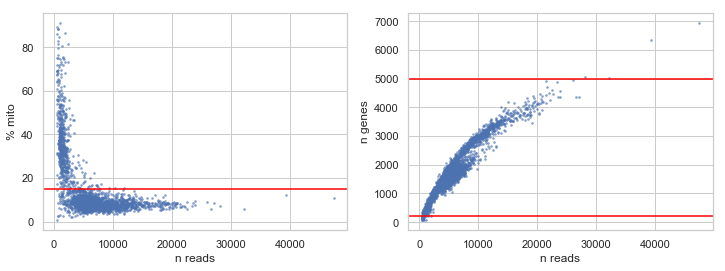

In [9]:
min_genes = 200
max_genes = 5000
mito_threshold = 15

fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(nreads, percent_mito, s=3, alpha=.5)
ax1.axhline(y=mito_threshold, color='red')
ax1.set_xlabel('n reads')
ax1.set_ylabel('% mito')
ax2 = plt.subplot(1, 2, 2)
ax2.scatter(nreads, ngenes, s=3, alpha=.5)
ax2.axhline(y=min_genes, color='red')
ax2.axhline(y=max_genes, color='red')
ax2.set_xlabel('n reads')
ax2.set_ylabel('n genes')
plt.show()

データフレームから条件を満たすcellのみを抽出する。

In [10]:
import gc

print('before filtering:', len(df.columns))
# numpy.logical_andが二条件しか引数にとらないので、reduceで複数条件を順次適用している。
# ちょっとわかりにくいので、
# np.all((ngenes > min_genes, ngenes < max_genes, percent_mito < mito_threshold), axis=0)
# でもOK.
filtered_cells_flags = np.logical_and.reduce((ngenes > min_genes, ngenes < max_genes, percent_mito < mito_threshold))
filtered_cells = df.columns[filtered_cells_flags]
df_filtered = df.loc[:, filtered_cells]

# メモリ節約...
del df
gc.collect()

print('after filtering:', len(df_filtered.columns))

before filtering: 2623
after filtering: 2020


# データの正規化

In [11]:
# 単純な万分率で正規化。
normalized = 10000 * df_filtered.values / df_filtered.values.sum(axis=0)
# 全体に1を足してlogをとる。np.log1p(x)はnp.log(1+x)と同じ意味だが、xが小さい時に丸め誤差の点でより安全。
lognormalized = np.log1p(normalized)
df_lognormalized = pd.DataFrame(lognormalized, index=df_filtered.index, columns=df_filtered.columns)

del df_filtered
gc.collect()

20

# 特徴量選択（発現量変動の大きい遺伝子）
SeuratやScanpyでは、実際はもう少し複雑に平均とばらつきを統計モデル化していて、1関数でモデリングと遺伝子抽出が実行できる。

ここでは単純にIndex of dispersion（ファノ因子、≠変動係数）によってざっくり抽出する。

,Symbol,Feature,Dispersion,AverageExpr
ENSG00000163220,S100A9,Gene Expression,5.287844,3.900304
ENSG00000251562,MALAT1,Gene Expression,5.060004,6.052159
ENSG00000090382,LYZ,Gene Expression,4.878848,4.100958
ENSG00000211592,IGKC,Gene Expression,4.831507,2.010695
ENSG00000211679,IGLC3,Gene Expression,4.684167,0.571297
ENSG00000211677,IGLC2,Gene Expression,4.637209,0.743293
ENSG00000143546,S100A8,Gene Expression,4.615651,3.043300
ENSG00000115523,GNLY,Gene Expression,4.599135,2.079986
ENSG00000169245,CXCL10,Gene Expression,4.562168,0.070199
ENSG00000087086,FTL,Gene Expression,4.344447,4.116171


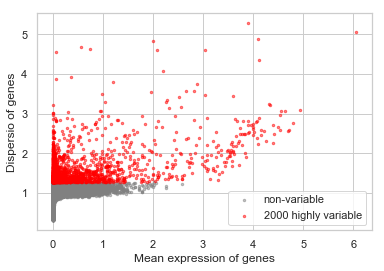

In [12]:
#変動の大きい順に2,000個抽出することにする
n_highly_variable = 2000

genes = genes.loc[df_lognormalized.index, :]
# logをとったデータなのでexpで戻して平均発現量計算する。expm1はlog1pと同様小さい値でより計算精度が高い
# 平均、分散は遺伝子ごとに計算なので、計算の方向は横方向（axis=1）
mean = np.expm1(df_lognormalized.values).mean(axis=1)
mean[mean == 0] = 1e-12
# Index of dispersion 参考： https://en.wikipedia.org/wiki/Index_of_dispersion
dispersion = np.expm1(df_lognormalized.values).var(axis=1, ddof=1) / mean  
dispersion[dispersion == 0] = np.nan
genes['Dispersion'] = np.log1p(dispersion)
genes['AverageExpr'] = np.log1p(mean)
# 遺伝子テーブルから、Dispersionの大きい順に上から2,000個取り出す
highly_variable_genes =genes.sort_values(by=['Dispersion'], ascending=False).head(n_highly_variable).index
display(genes.loc[highly_variable_genes, :].head(10))

isHVG = genes.index.isin(highly_variable_genes)

fig, ax = plt.subplots()
ax.scatter(genes.loc[~isHVG, 'AverageExpr'], genes.loc[~isHVG, 'Dispersion'], c='gray', s=6, alpha=.5, label='non-variable')
ax.scatter(genes.loc[isHVG, 'AverageExpr'], genes.loc[isHVG, 'Dispersion'], c='red', s=6, alpha=.5, label='{} highly variable'.format(n_highly_variable))
ax.set_xlabel('Mean expression of genes')
ax.set_ylabel('Dispersio of genes')
plt.legend()
plt.show()

In [13]:
# 正規化テーブルから、highly variable genesの項目のみ抽出
df_HVGs = df_lognormalized.loc[isHVG, :]
print(df_HVGs.shape)

del df_lognormalized
gc.collect()

(2000, 2020)


48

# データの標準化

In [14]:
# 平均0, 分散1に標準化する
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_HVGs.values.T)
scaled_values = np.clip(scaled_values, None, 10)
df_scaled = pd.DataFrame(scaled_values.T, index=df_HVGs.index, columns=df_HVGs.columns)

# 行列分解による次元削減
## 1. Principal Component Analysis（主成分分析）

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# 大抵のモデルは（サンプル x 特徴量）の行列を入力するので、逆の場合は転置（.T）して入力
pca.fit(df_scaled.values.T)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [16]:
x = pca.transform(df_scaled.values.T)

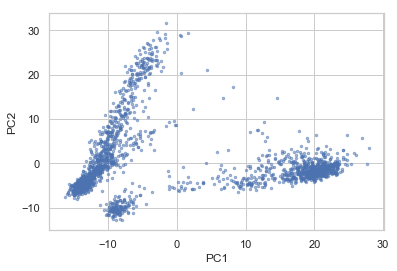

In [17]:
fig, ax = plt.subplots()
ax.scatter(x[:, 0], x[:, 1], s=6, alpha=.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

In [18]:
# 因子負荷量の計算
#factor loadings =  eigenvector * sqrt(envenvalue)
factor_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# 第一主成分に対する因子負荷量、絶対値の大きい順に上から10個
top10_pc1_ind = np.argsort(np.abs(factor_loadings[:, 0]))[::-1][:10]
top10_pc1_genes = genes.loc[df_scaled.index[top10_pc1_ind], :]
top10_pc1_genes['FactorLoadings'] = factor_loadings[top10_pc1_ind, 0]
display(top10_pc1_genes)

# 第二主成分に対する因子負荷量、絶対値の大きい順に上から10個
top10_pc2_ind = np.argsort(np.abs(factor_loadings[:, 1]))[::-1][:10]
top10_pc2_genes = genes.loc[df_scaled.index[top10_pc2_ind], :]
top10_pc2_genes['FactorLoadings'] = factor_loadings[top10_pc2_ind, 1]
display(top10_pc2_genes)

,Symbol,Feature,Dispersion,AverageExpr,FactorLoadings
ENSG00000085265,FCN1,Gene Expression,3.154801,2.325282,0.945878
ENSG00000090382,LYZ,Gene Expression,4.878848,4.100958,0.943278
ENSG00000163563,MNDA,Gene Expression,2.750382,1.846633,0.932165
ENSG00000101439,CST3,Gene Expression,3.432038,2.521091,0.922486
ENSG00000163131,CTSS,Gene Expression,3.179421,2.558866,0.917597
ENSG00000177954,RPS27,Gene Expression,3.255650,4.314719,-0.910389
ENSG00000197746,PSAP,Gene Expression,2.659455,2.053708,0.909518
ENSG00000163220,S100A9,Gene Expression,5.287844,3.900304,0.909191
ENSG00000011600,TYROBP,Gene Expression,2.661006,2.180882,0.902882
ENSG00000127951,FGL2,Gene Expression,2.149477,1.396505,0.894918


,Symbol,Feature,Dispersion,AverageExpr,FactorLoadings
ENSG00000105374,NKG7,Gene Expression,4.079863,2.205202,0.860561
ENSG00000077984,CST7,Gene Expression,2.641890,1.038269,0.838332
ENSG00000180644,PRF1,Gene Expression,2.783907,0.857026,0.831541
ENSG00000145649,GZMA,Gene Expression,2.842264,1.284424,0.823727
ENSG00000134539,KLRD1,Gene Expression,2.579115,0.760472,0.801405
ENSG00000137441,FGFBP2,Gene Expression,3.056728,0.942053,0.791027
ENSG00000100450,GZMH,Gene Expression,2.953108,0.978918,0.787740
ENSG00000115523,GNLY,Gene Expression,4.599135,2.079986,0.781842
ENSG00000172543,CTSW,Gene Expression,2.370474,0.859289,0.760915
ENSG00000150045,KLRF1,Gene Expression,2.317932,0.507190,0.747323


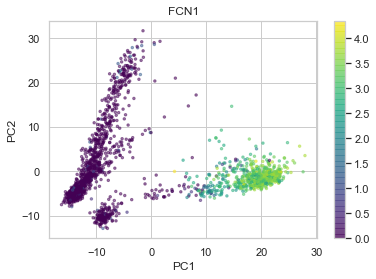

In [19]:
# 遺伝子名を指定して、PCA上で発現量を見てみる。
# 遺伝子名入れたら図を描く関数を作っておく
def plot_gene_expression(target_gene):
    target_gene_id = genes[genes['Symbol'] == target_gene].index[0]
    expr_values = df_HVGs.loc[target_gene_id, :]
    fig, ax = plt.subplots()
    sc = ax.scatter(x[:, 0], x[:, 1], s=6, alpha=.5, c=expr_values, cmap='viridis')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(target_gene)
    plt.colorbar(sc)
    plt.show()

plot_gene_expression('FCN1')

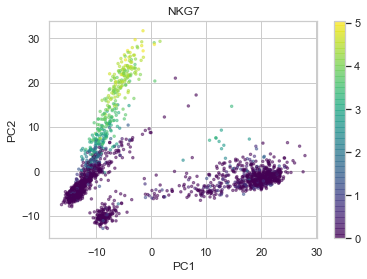

In [20]:
plot_gene_expression('NKG7')

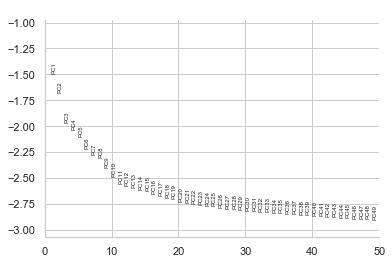

In [21]:
# それぞれの主成分の寄与率を見てみる
n_pcs = 50
pca = PCA(n_components=n_pcs)
pca.fit(df_scaled.values.T)
variance_ratio = np.log10(pca.explained_variance_ratio_)

fig, ax = plt.subplots()
for i in range(n_pcs):
    ax.annotate('PC'+str(i), xy=(i, variance_ratio[i]), ha='left', rotation=90, fontsize=6)
ax.set_xlim(0, n_pcs)
ax.set_ylim(variance_ratio.min()*1.1, variance_ratio.max()*1.1)
sns.despine()
plt.show()

## 2. Non-negative Matrix Factorization（非負値行列因子分解）


In [22]:
from sklearn.decomposition import NMF

Original


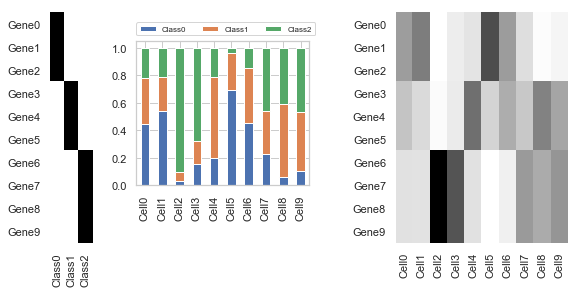

Reconstructed


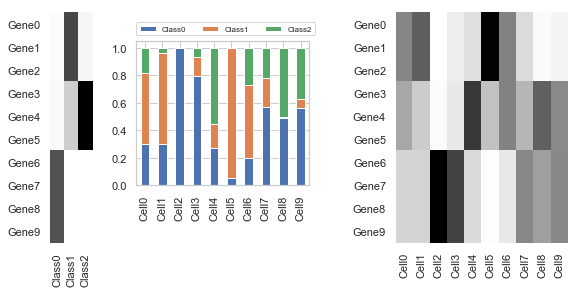

In [23]:
# 擬似データでNMFのデモ

def plot_W_H_X(W, H, X):
    tmp_classes = ['Class%d'%x for x in range(W.shape[1])]
    tmp_genes = ['Gene%d'%x for x in range(W.shape[0])]
    tmp_cells = ['Cell%d'%x for x in range(H.shape[1])]
    fig = plt.figure()
    ax1 = plt.axes([0.0, 0.1, 0.1, 0.8])
    sns.heatmap(pd.DataFrame(W, index=tmp_genes, columns=tmp_classes), cmap='Greys', cbar=False, ax=ax1)
    ax2 = plt.axes([0.2, 0.3, 0.4, 0.5])
    pd.DataFrame(H, index=tmp_classes, columns=tmp_cells).transpose().plot.bar(stacked=True, ax=ax2)
    plt.legend(loc=(0., 1.04), ncol=3, fontsize=8)
    ax3 = plt.axes([0.8, 0.1, 0.4, 0.8])
    sns.heatmap(pd.DataFrame(X, index=tmp_genes, columns=tmp_cells), cmap='Greys', cbar=False)
    plt.show()

print('Original')
                   # class-0 は最初の3個の遺伝子を発現
tmp_genes = np.array([[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                  # class-1 はまんなか3個の遺伝子を発現
                   [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                  # class-2 はうしろ4個の遺伝子を発現
                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]]).T
# 各cellがclass-0, class-1, class2をどういう割合で持っているか
tmp_cells = np.random.dirichlet(alpha=[1.0]*3, size=10).T
# 遺伝子発現テーブルはその掛け算で決まっている（と仮定する）
original_expression_data = np.dot(tmp_genes, tmp_cells)
plot_W_H_X(tmp_genes, tmp_cells, original_expression_data)

print('Reconstructed')
# 遺伝子発現テーブルだけを使って、クラスごとの発現パターンベクトル、サンプルごとのクラス割合を復元する
model = NMF(n_components=3, random_state=42)
W = model.fit_transform(original_expression_data)
W /= W.sum(axis=0)
H = model.components_
H /= H.sum(axis=0)
X = np.dot(W, H)
plot_W_H_X(W, H, X)

シングルセルデータにNMFを適用してみる。

In [24]:
model = NMF(n_components=2, solver='mu', beta_loss='kullback-leibler')
#model = NMF(n_components=2, solver='mu', beta_loss='itakura-saito')
W = model.fit_transform(df_HVGs.values)
H = model.components_

print('Original shape=',df_HVGs.values.shape)
print('W shape =',W.shape)
print('H shape =',H.shape)

Original shape= (2000, 2020)
W shape = (2000, 2)
H shape = (2, 2020)


NMFの結果は次元削減として利用できる。最初の30細胞だけ見てみる。  
また、各細胞でもっとも値の高いクラスに割り当てることでクラスタリングの代わりとしてしまうこともある。

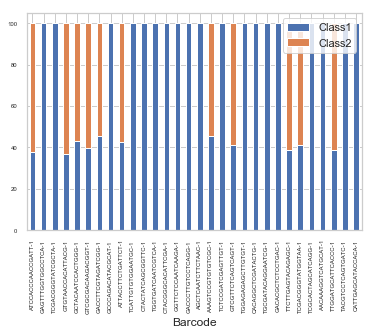

In [25]:
H_percentage = 100.0 * H / H.sum(axis=0)
pd.DataFrame(H_percentage[:, :30].T, index=df_HVGs.columns[:30], 
             columns=['Class1', 'Class2']).plot.bar(stacked=True, fontsize=6)

それぞれのクラスへの寄与が大きい遺伝子はなにか？

In [26]:
topN = 10
class1_top_gene_ind = df_HVGs.index[np.argsort(W[:, 0])[::-1][:topN]]
display(genes.loc[class1_top_gene_ind, :])

class2_top_gene_ind = df_HVGs.index[np.argsort(W[:, 1])[::-1][:topN]]
display(genes.loc[class2_top_gene_ind, :])

,Symbol,Feature,Dispersion,AverageExpr
ENSG00000251562,MALAT1,Gene Expression,5.060004,6.052159
ENSG00000198899,MT-ATP6,Gene Expression,2.767095,4.797475
ENSG00000198938,MT-CO3,Gene Expression,2.589297,4.719932
ENSG00000198712,MT-CO2,Gene Expression,2.553493,4.702474
ENSG00000166710,B2M,Gene Expression,3.063975,4.645228
ENSG00000167526,RPL13,Gene Expression,3.060281,4.548161
ENSG00000147403,RPL10,Gene Expression,2.976620,4.541619
ENSG00000156508,EEF1A1,Gene Expression,2.660101,4.500889
ENSG00000198886,MT-ND4,Gene Expression,2.268463,4.405573
ENSG00000137818,RPLP1,Gene Expression,2.476907,4.412944


,Symbol,Feature,Dispersion,AverageExpr
ENSG00000090382,LYZ,Gene Expression,4.878848,4.100958
ENSG00000163220,S100A9,Gene Expression,5.287844,3.900304
ENSG00000101439,CST3,Gene Expression,3.432038,2.521091
ENSG00000143546,S100A8,Gene Expression,4.615651,3.043300
ENSG00000085265,FCN1,Gene Expression,3.154801,2.325282
ENSG00000163131,CTSS,Gene Expression,3.179421,2.558866
ENSG00000087086,FTL,Gene Expression,4.344447,4.116171
ENSG00000204287,HLA-DRA,Gene Expression,3.754472,2.883709
ENSG00000245532,NEAT1,Gene Expression,3.478594,3.040981
ENSG00000011600,TYROBP,Gene Expression,2.661006,2.180882


[]

<Figure size 648x1152 with 0 Axes>

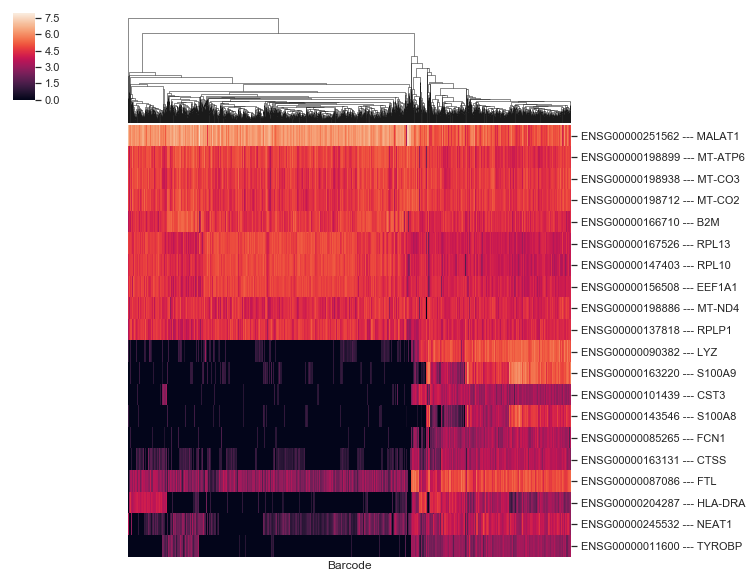

In [27]:
gene_labels1 = list(class1_top_gene_ind + ' --- ' + genes.loc[class1_top_gene_ind, 'Symbol'])
gene_labels2 = list(class2_top_gene_ind + ' --- ' + genes.loc[class2_top_gene_ind, 'Symbol'])

fig = plt.figure(figsize=(9,16))
c = sns.clustermap(df_HVGs.loc[list(class1_top_gene_ind) + list(class2_top_gene_ind)], 
    row_cluster=False, col_cluster=True, yticklabels=gene_labels1+gene_labels2)
c.ax_heatmap.set_xticks([])

いくつの細胞クラスに分解すればいいのか？  
※メモリなど計算環境に余裕のある人だけ。

In [28]:
reconstruction_errors = []
for classes in range(2, 15):
    print(f' Now calculating {classes} classes NMF...')
    #model = NMF(n_components=classes, solver='mu', beta_loss='kullback-leibler')
    model = NMF(n_components=classes)
    W = model.fit_transform(df_HVGs.values)
    reconstruction_errors.append(model.reconstruction_err_)

 Now calculating 2 classes NMF...
 Now calculating 3 classes NMF...
 Now calculating 4 classes NMF...
 Now calculating 5 classes NMF...
 Now calculating 6 classes NMF...
 Now calculating 7 classes NMF...
 Now calculating 8 classes NMF...
 Now calculating 9 classes NMF...
 Now calculating 10 classes NMF...
 Now calculating 11 classes NMF...
 Now calculating 12 classes NMF...
 Now calculating 13 classes NMF...
 Now calculating 14 classes NMF...


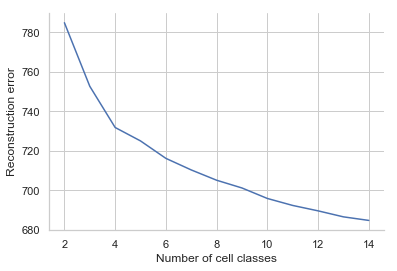

In [29]:
reconstruction_errors = np.array(reconstruction_errors)
fig, ax = plt.subplots()
ax.plot(np.arange(2, 15), reconstruction_errors)
ax.set_xlabel('Number of cell classes')
ax.set_ylabel('Reconstruction error')
sns.despine()
plt.show()

# 非線形次元削減

PCA: 0.0013 sec
MDS: 1.6 sec
t-SNE: 5.5 sec
UMAP: 3.6 sec


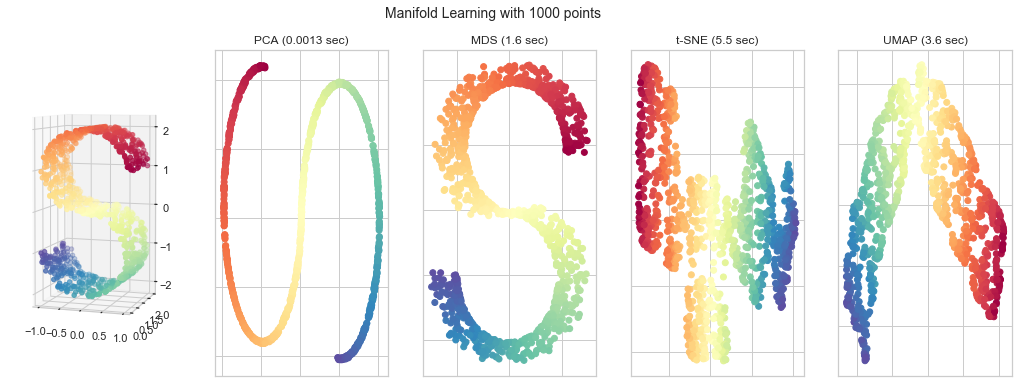

In [30]:
#非線形次元圧縮、各手法の比較
#他の手法は以下のURLを参照
#https://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html

from time import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
import umap

n_points = 1000
X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
n_components = 2

fig = plt.figure(figsize=(18, 6))
plt.suptitle(f"Manifold Learning with {n_points} points", fontsize=14)
ax = fig.add_subplot(151, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

def plot2d(model, model_name, index):
    t0 = time()
    Y = model.fit_transform(X)
    t1 = time()
    print(f"{model_name}: {t1-t0:.2g} sec")
    ax = fig.add_subplot(1, 5, index)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title(f"{model_name} ({t1-t0:.2g} sec)")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

model = PCA(n_components=2)
plot2d(model, 'PCA', 2)

model = manifold.MDS(n_components=2, max_iter=100, n_init=1)
plot2d(model, 'MDS', 3)

model = manifold.TSNE(n_components=2, 
                      init='pca', perplexity=50, random_state=0)
plot2d(model, 't-SNE', 4)

model = umap.UMAP(n_components=2, 
                  n_neighbors=30, min_dist=0.3, random_state=0)
plot2d(model, 'UMAP', 5)

plt.show()

## 1. t-SNE（t分布型確率的近傍埋め込み）

In [31]:
# ここでは計算効率のため、非線形圧縮をする前に、50個くらいの主成分で線形圧縮しておく。
#（重要なばらつきは大体キャプチャできてる、と考えておく）
PCs = 50
pca = PCA(n_components=PCs)
pcscores = pca.fit_transform(df_scaled.values.T)
df_pc = pd.DataFrame(pcscores, index=df_scaled.columns, columns=['PC'+str(i+1) for i in range(PCs)])
display(df_pc.head())

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
Barcode,,,,,,,,,,,,,,,,,,,,,
ATCCACCCAACCGATT-1,20.673525,-1.653045,-2.885293,4.138028,-0.567040,-6.255943,0.088575,-3.319000,2.748690,-0.876050,...,1.361851,-1.699506,2.246626,-0.575961,1.266507,1.065215,0.002746,-0.069993,0.991368,0.717919
GAGTTTGGTGGCCTCA-1,-10.751574,-0.644390,-2.338382,0.290855,1.824604,2.426661,-1.304186,-2.072389,0.177227,-1.224068,...,0.181991,0.814264,0.218958,1.378022,0.729102,-0.478025,0.528459,-0.259027,0.212394,-0.718996
TCGACGGGTATCGCTA-1,-6.877502,15.229161,3.134328,-1.580090,-1.355602,1.288947,-1.842067,-0.266164,-0.179152,-0.499721,...,0.047332,3.426248,-0.488987,1.652990,-1.355910,-1.635505,-0.514096,-0.574462,0.609125,-1.305111
GTGTAACCACATTACG-1,21.028371,-1.246771,-1.372902,5.358743,0.188505,-8.747760,0.037741,-3.277246,3.781364,1.153989,...,-2.010804,1.148727,0.599253,0.527849,1.621302,0.041127,-1.502737,0.268439,0.260064,-1.760475
GCTACAATCCACTGGG-1,17.463933,-0.651213,0.345150,-1.895788,-0.354137,3.360727,0.803777,1.175313,1.659375,-1.474018,...,-0.129316,-0.827586,0.089218,0.187765,-0.886201,-0.090087,0.367756,0.458922,-0.347072,0.434758


In [32]:
# t-SNEの実行
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', verbose=1)
tsne_coords = tsne.fit_transform(df_pc.values)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2020 samples in 0.003s...
[t-SNE] Computed neighbors for 2020 samples in 0.259s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2020
[t-SNE] Computed conditional probabilities for sample 2000 / 2020
[t-SNE] Computed conditional probabilities for sample 2020 / 2020
[t-SNE] Mean sigma: 3.466820
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.528778
[t-SNE] KL divergence after 1000 iterations: 1.238136


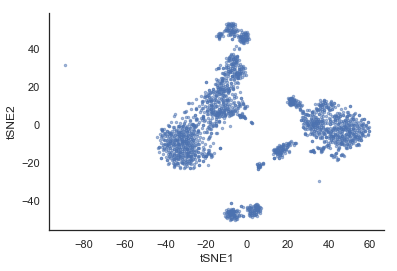

In [33]:
sns.set(style='white')
fig, ax = plt.subplots()
ax.scatter(tsne_coords[:, 0], tsne_coords[:, 1], s=6, alpha=.5)
ax.set_xlabel('tSNE1')
ax.set_ylabel('tSNE2')
sns.despine()
plt.show()

In [34]:
# Perplexityの設定でt-SNEの結果（プロットの見た目）は全然変わってくる
# Perplexity、5にした場合、30にした場合（デフォルト。前セル）、500にした場合で比較してみる
tsne5 = TSNE(n_components=2, init='pca', verbose=1, perplexity=5)
coords5 = tsne5.fit_transform(df_pc.values)
tsne500 = TSNE(n_components=2, init='pca', verbose=1, perplexity=500)
coords500 = tsne500.fit_transform(df_pc.values)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2020 samples in 0.003s...
[t-SNE] Computed neighbors for 2020 samples in 0.196s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2020
[t-SNE] Computed conditional probabilities for sample 2000 / 2020
[t-SNE] Computed conditional probabilities for sample 2020 / 2020
[t-SNE] Mean sigma: 2.355137
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.313896
[t-SNE] KL divergence after 1000 iterations: 1.590071
[t-SNE] Computing 1501 nearest neighbors...
[t-SNE] Indexed 2020 samples in 0.000s...
[t-SNE] Computed neighbors for 2020 samples in 0.300s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2020
[t-SNE] Computed conditional probabilities for sample 2000 / 2020
[t-SNE] Computed conditional probabilities for sample 2020 / 2020
[t-SNE] Mean sigma: 7.244504
[t-SNE] KL divergence after 250 iterations with early exaggeration: 38.991486
[t-SNE] KL divergence after 1000 iterations: 0.18940

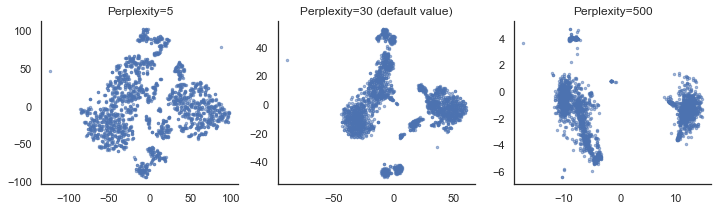

In [35]:
fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(1,3,1)
ax1.scatter(coords5[:, 0], coords5[:, 1], s=6, alpha=.5)
ax1.set_title('Perplexity=5')
ax2 = fig.add_subplot(1,3,2)
ax2.scatter(tsne_coords[:, 0], tsne_coords[:, 1], s=6, alpha=.5)
ax2.set_title('Perplexity=30 (default value)')
ax3 = fig.add_subplot(1,3,3)
ax3.scatter(coords500[:, 0], coords500[:, 1], s=6, alpha=.5)
ax3.set_title('Perplexity=500')
sns.despine()
plt.show()

## 2. UMAP (Uniform Manifold Approximation and Projection)
なぜか最近異様にたくさん使われている

In [36]:
import umap
umap_model = umap.UMAP(n_components=2, \
                       n_neighbors=30, min_dist=0.3, metric='cosine',  \
                       random_state=42, verbose=True)
umap_coords = umap_model.fit_transform(df_pc.values)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='cosine',
     metric_kwds=None, min_dist=0.3, n_components=2, n_epochs=None,
     n_neighbors=30, negative_sample_rate=5, random_state=42,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Mon Oct  7 17:15:13 2019 Finding Nearest Neighbors
Mon Oct  7 17:15:13 2019 Finished Nearest Neighbor Search
Mon Oct  7 17:15:13 2019 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Oct  7 17:15:

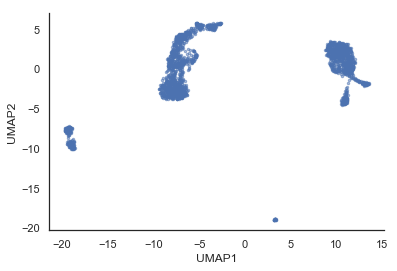

In [37]:
fig, ax = plt.subplots()
ax.scatter(umap_coords[:, 0], umap_coords[:, 1], s=6, alpha=.5)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
sns.despine()
plt.show()

In [38]:
# ここでもパラメータを色々変えて結果を比較してみる。
# 重要なパラメータは2つ: n_neighbors, min_dist
# まずはn_neighbors、5個、30個（前セル）、500個で比較
umap_model5 = umap.UMAP(n_components=2, \
                       n_neighbors=5, min_dist=0.3, metric='cosine',  \
                       random_state=42, verbose=True)
umap_coords5 = umap_model5.fit_transform(df_pc.values)
umap_model500 = umap.UMAP(n_components=2, \
                       n_neighbors=500, min_dist=0.3, metric='cosine',  \
                       random_state=42, verbose=True)
umap_coords500 = umap_model500.fit_transform(df_pc.values)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='cosine',
     metric_kwds=None, min_dist=0.3, n_components=2, n_epochs=None,
     n_neighbors=5, negative_sample_rate=5, random_state=42,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Mon Oct  7 17:15:17 2019 Finding Nearest Neighbors
Mon Oct  7 17:15:17 2019 Finished Nearest Neighbor Search
Mon Oct  7 17:15:17 2019 Construct embedding


/Users/higashi/.pyenv/versions/3.7.2/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Oct  7 17:15:19 2019 Finished embedding
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='cosine',
     metric_kwds=None, min_dist=0.3, n_components=2, n_epochs=None,
     n_neighbors=500, negative_sample_rate=5, random_state=42,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Mon Oct  7 17:15:19 2019 Finding Nearest Neighbors
Mon Oct  7 17:15:19 2019 Finished Nearest Neighbor Search
Mon Oct  7 17:15:

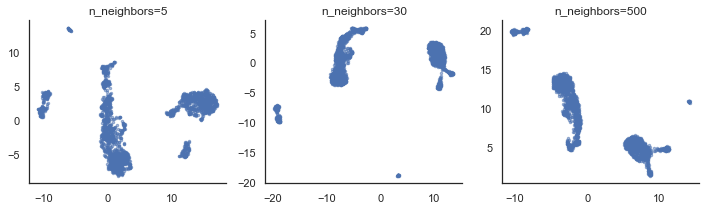

In [39]:
fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(1,3,1)
ax1.scatter(umap_coords5[:, 0], umap_coords5[:, 1], s=6, alpha=.5)
ax1.set_title('n_neighbors=5')
ax2 = fig.add_subplot(1,3,2)
ax2.scatter(umap_coords[:, 0], umap_coords[:, 1], s=6, alpha=.5)
ax2.set_title('n_neighbors=30')
ax3 = fig.add_subplot(1,3,3)
ax3.scatter(umap_coords500[:, 0], umap_coords500[:, 1], s=6, alpha=.5)
ax3.set_title('n_neighbors=500')
sns.despine()
plt.show()

In [40]:
# min_dist、0.01、0.03、0.8で比較
umap_model_mindist001 = umap.UMAP(n_components=2, \
                       n_neighbors=30, min_dist=0.01, metric='cosine',  \
                       random_state=42, verbose=True)
umap_coords_mindist001 = umap_model_mindist001.fit_transform(df_pc.values)
umap_model_mindist08 = umap.UMAP(n_components=2, \
                       n_neighbors=30, min_dist=0.8, metric='cosine',  \
                       random_state=42, verbose=True)
umap_coords_mindist08 = umap_model_mindist08.fit_transform(df_pc.values)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='cosine',
     metric_kwds=None, min_dist=0.01, n_components=2, n_epochs=None,
     n_neighbors=30, negative_sample_rate=5, random_state=42,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Mon Oct  7 17:15:26 2019 Finding Nearest Neighbors
Mon Oct  7 17:15:27 2019 Finished Nearest Neighbor Search
Mon Oct  7 17:15:27 2019 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Oct  7 17:15

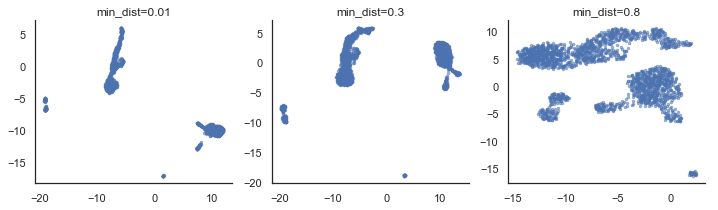

In [41]:
fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(1,3,1)
ax1.scatter(umap_coords_mindist001[:, 0], umap_coords_mindist001[:, 1], s=6, alpha=.5)
ax1.set_title('min_dist=0.01')
ax2 = fig.add_subplot(1,3,2)
ax2.scatter(umap_coords[:, 0], umap_coords[:, 1], s=6, alpha=.5)
ax2.set_title('min_dist=0.3')
ax3 = fig.add_subplot(1,3,3)
ax3.scatter(umap_coords_mindist08[:, 0], umap_coords_mindist08[:, 1], s=6, alpha=.5)
ax3.set_title('min_dist=0.8')
sns.despine()
plt.show()

# クラスタリング

## 1. 階層的クラスタリング

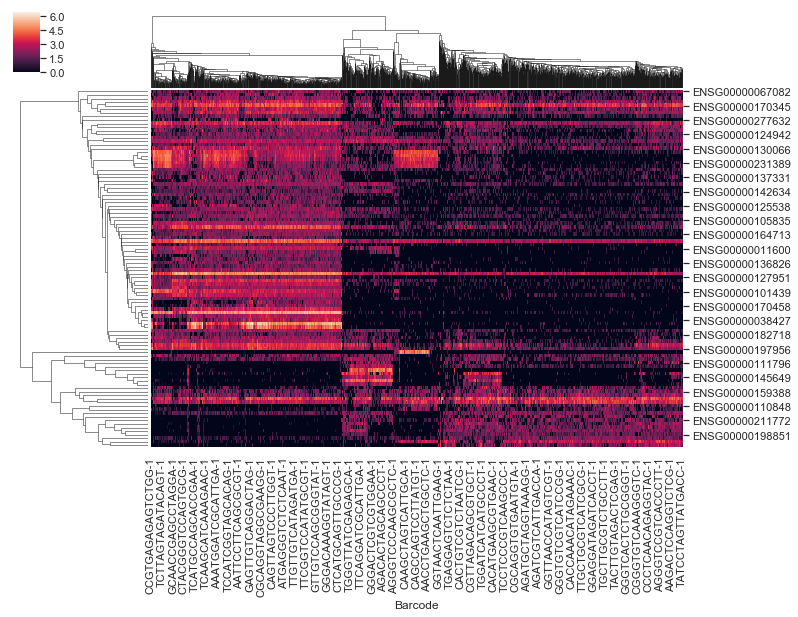

In [42]:
# 発現量のcell間分散がTop-100の遺伝子だけ抜き出し
top100_df = df_HVGs.loc[df_HVGs.var(axis=1).sort_values(ascending=False).index[:100], :]

sns.clustermap(top100_df, method='average', metric='correlation', figsize=(12, 8))

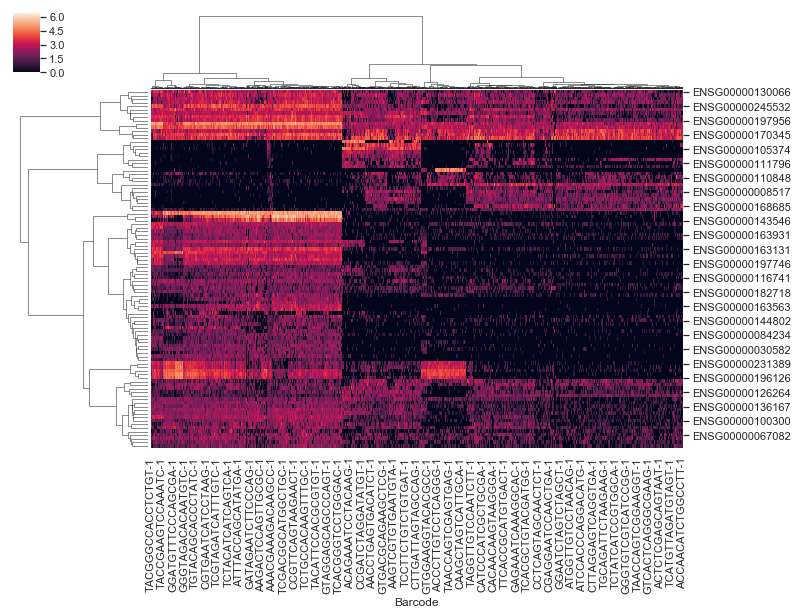

In [43]:
# サンプル間の距離計算手法、クラスター間の距離計算手法による違い
sns.clustermap(top100_df, method='ward', metric='euclidean', figsize=(12,8))

## 2. k-meansクラスタリング

In [44]:
import sklearn.cluster
model = sklearn.cluster.KMeans(n_clusters=2)
y = model.fit_predict(df_pc.values)
print(y)
print('cluster-0:', np.count_nonzero(y == 0), ' cluster-1:', np.count_nonzero(y == 1))

[1 0 0 ... 0 0 0]
cluster-0: 1292  cluster-1: 728


In [45]:
umap_model = umap.UMAP(n_components=2, \
                       n_neighbors=30, min_dist=0.3, metric='cosine',  \
                       random_state=42, verbose=False)
umap_coords = umap_model.fit_transform(df_pc.values)

clusters: 2
clusters: 3
clusters: 4
clusters: 5
clusters: 6
clusters: 7


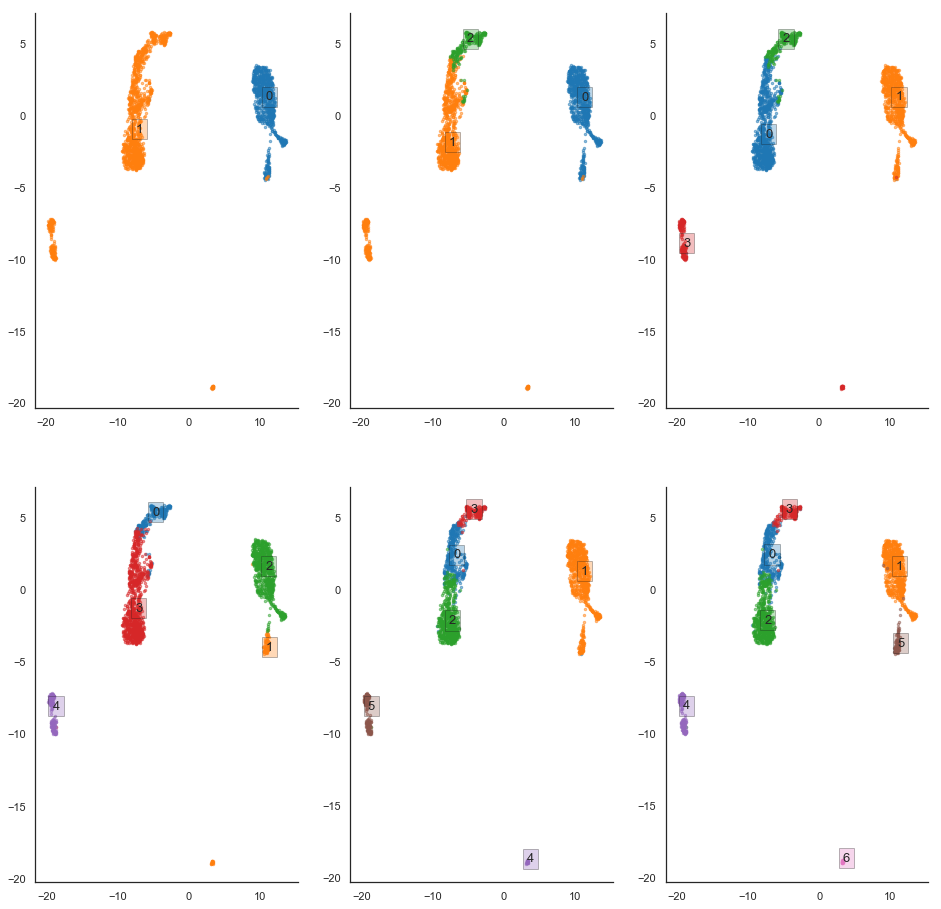

In [46]:
from matplotlib import cm
colors = [matplotlib.colors.to_hex(x) for x in cm.tab10.colors]

fig = plt.figure(figsize=(16,16))

def plot_clusters(n_clusters):
    model = sklearn.cluster.KMeans(n_clusters=n_clusters)
    y = model.fit_predict(df_pc.values)
    ax = fig.add_subplot(2, 3, n_clusters-1)
    for cl_id in list(set(y)):
        ax.scatter(umap_coords[y == cl_id, 0], umap_coords[y == cl_id, 1], \
               s=6, alpha=.5, \
               c=colors[cl_id])
    for cl_id in list(set(y)):
        coord_m = np.median(umap_coords[y == cl_id, :], axis=0)
        ax.annotate(str(cl_id), xy=(coord_m), \
              fontsize=13, \
              bbox={"facecolor":colors[cl_id], "edgecolor":"k", "alpha":0.3})
    sns.despine()

for n_clusters in range(2, 8):
    print('clusters:', n_clusters)
    plot_clusters(n_clusters)

plt.show()

## 3. グラフベースのクラスタリング

In [47]:
# 距離行列の構築
from scipy.spatial.distance import pdist, squareform
D = squareform(pdist(df_pc.values, metric='euclidean'))

In [48]:
# n_neighborsの設定。近傍15個のサンプルをつなぐようにする
n_neighbors = 15
# 距離行列で最大n_neighborsまで小さい距離を集めて切り出す。（numpy.argpartition関数。全体をsortするより高速）
knn_indices = np.argpartition(D, n_neighbors-1, axis=1)[:, :n_neighbors]
# 切り出された、各サンプルn_neighbors個の中でsort
sample_indices = np.arange(D.shape[0])[:, None]
# サンプルごと、15近傍サンプルのインデックス
knn_indices = knn_indices[sample_indices, np.argsort(D[sample_indices, knn_indices])]
# サンプルごと、15近傍サンプルへの距離
knn_distances = D[sample_indices, knn_indices]
print(knn_indices)

[[   0 1876  395 ... 1124 1712  692]
 [   1 1413 1700 ... 1558  651 1207]
 [   2  803 1866 ...  107 1630 1514]
 ...
 [2017  989  741 ... 1854 1672   66]
 [2018  999 1717 ... 1409 1149 1334]
 [2019  522 1072 ...  191  536 2002]]


In [49]:
#umapのfuzzy_simplicial_set関数で無向グラフ構築とエッジ重み付けを行う。
from umap.umap_ import fuzzy_simplicial_set
connectivities = fuzzy_simplicial_set(df_pc.values, n_neighbors, random_state=42, metric=None, \
                                          knn_indices=knn_indices, knn_dists=knn_distances)

In [50]:
print(type(connectivities),'\n')
print(connectivities) # scipyの疎行列として格納されている。(サンプル i, サンプル j) 重み

<class 'scipy.sparse.csr.csr_matrix'> 

  (0, 3)	0.03417484792156331
  (0, 108)	0.16669816593390324
  (0, 184)	0.2235625968219223
  (0, 395)	0.7248897931287415
  (0, 567)	0.5901890875113434
  (0, 692)	0.09006468767285107
  (0, 903)	0.1397417937280208
  (0, 915)	0.12623227074956522
  (0, 1116)	0.13103787613212325
  (0, 1124)	0.1120522723380262
  (0, 1499)	0.9999999999999999
  (0, 1600)	0.12943130848078765
  (0, 1612)	0.31759804641681266
  (0, 1712)	0.11203349424975662
  (0, 1876)	0.9999999999999999
  (0, 1998)	0.17512067778864654
  (1, 49)	1.0
  (1, 113)	0.12591893106897004
  (1, 181)	0.23561358469530874
  (1, 221)	0.23901335970256346
  (1, 245)	0.2427874228309384
  (1, 254)	0.5335387254719359
  (1, 294)	1.0
  (1, 316)	0.6854548448531316
  (1, 434)	0.2333900601219789
  :	:
  (2018, 999)	1.0
  (2018, 1060)	0.36023629442481425
  (2018, 1064)	0.1668627222054036
  (2018, 1149)	0.07935067093329283
  (2018, 1181)	0.1776783466348111
  (2018, 1334)	0.07344110654668025
  (2018, 1409)	0.083577068

In [51]:
# 疎行列グラフをigraph形式に変換
import igraph as ig
sources, targets = connectivities.nonzero()
weights = connectivities[sources, targets]
g = ig.Graph()
# 頂点の追加
g.add_vertices(connectivities.shape[0])
# 辺の追加
g.add_edges(list(zip(sources, targets)))
g.es['weight'] = weights

In [52]:
# グラフ分割
import leidenalg
part = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition, 
    weights=np.array(weights)[0], resolution_parameter=0.5, seed=42)
louvain_groups = np.array(part.membership)

In [53]:
print(louvain_groups)
print(louvain_groups.shape)
print(louvain_groups.min(), louvain_groups.max())

[0 1 1 ... 3 3 4]
(2020,)
0 6


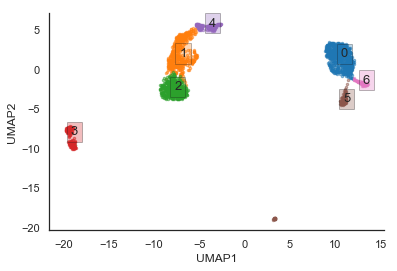

In [54]:
# クラスタリング結果を描画してみる
from matplotlib import cm
colors = [matplotlib.colors.to_hex(x) for x in cm.tab10.colors]

fig, ax = plt.subplots()
for cl_id in list(set(louvain_groups)):
    ax.scatter(umap_coords[louvain_groups == cl_id, 0], umap_coords[louvain_groups == cl_id, 1], \
               s=6, alpha=.5, \
               c=colors[cl_id])
    
for cl_id in list(set(louvain_groups)):
    coord_m = np.median(umap_coords[louvain_groups == cl_id, :], axis=0)
    ax.annotate(str(cl_id), xy=(coord_m), \
              fontsize=13, \
              bbox={"facecolor":colors[cl_id], "edgecolor":"k", "alpha":0.3})
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
sns.despine()
plt.show()

## 4. 密度ベースのクラスタリング

In [55]:
from sklearn.cluster import DBSCAN

まず、データ点間の距離がどんな分布になっているのか、なんとなく把握する。

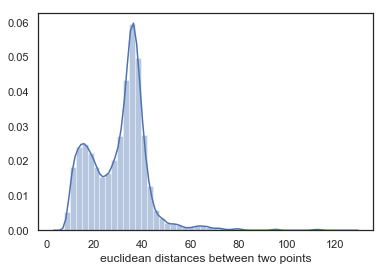

In [56]:
distances = pdist(df_pc.values, metric='euclidean')
sns.distplot(distances, axlabel='euclidean distances between two points')

とりあえず、eps=10くらいで計算してみる。

In [57]:
model = DBSCAN(eps=10, min_samples=10)
model.fit(df_pc.values)

DBSCAN(algorithm='auto', eps=10, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [58]:
print(list(set(model.labels_)))
for cl_id in list(set(model.labels_)):
    if cl_id == -1:
        print('Noise samples:', np.count_nonzero(model.labels_ == -1))
    else:
        print(f'cluster-{cl_id} samples:', np.count_nonzero(model.labels_ == cl_id))

[0, 1, 2, -1]
cluster-0 samples: 667
cluster-1 samples: 471
cluster-2 samples: 37
Noise samples: 845


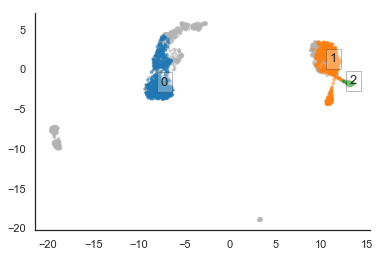

In [59]:
def plot_clusters(coords, groups, title, ax):
    colors = [matplotlib.colors.to_hex(x) for x in cm.tab10.colors]
    cluster_colors = np.array([colors[x] if x >= 0 else (0.7, 0.7, 0.7) for x in groups])
    for cl_id in sorted(list(set(groups))):
        ax.scatter(coords[groups == cl_id, 0], coords[groups == cl_id, 1], \
                   s=6, alpha=.5, c=cluster_colors[groups == cl_id])
    for cl_id in list(set(groups)):
        if cl_id == -1:
            continue
        coord_m = np.median(coords[groups == cl_id, :], axis=0)
        ax.annotate(str(cl_id), xy=(coord_m), \
                  fontsize=13, \
                  bbox={"facecolor":"w", "edgecolor":"k", "alpha":0.3})
    ax.set_title(title)
    sns.despine()

fig, ax = plt.subplots()
plot_clusters(umap_coords, model.labels_, None, ax)
plt.show()

epsパラメータで比較してみる。

dbscan. eps=5...
dbscan. eps=7...
dbscan. eps=9...
dbscan. eps=11...
dbscan. eps=13...
dbscan. eps=15...
dbscan. eps=17...
dbscan. eps=19...
dbscan. eps=21...


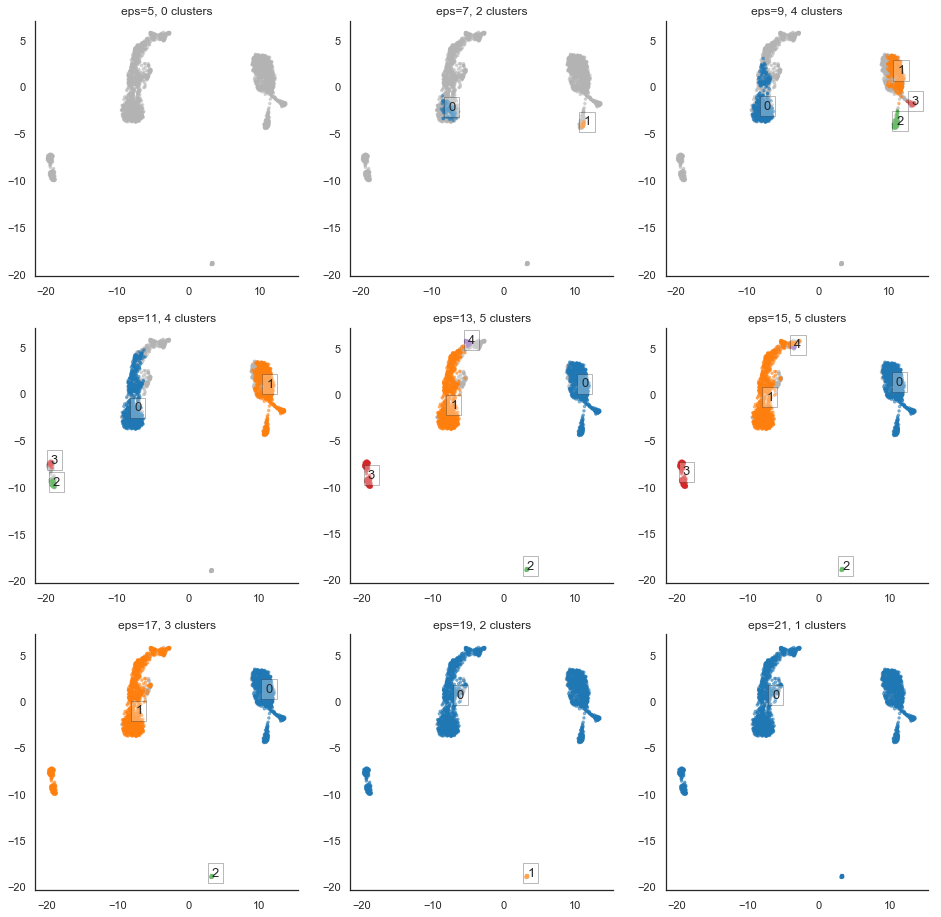

In [60]:
fig = plt.figure(figsize=(16,16))

for i, eps in enumerate([5, 7, 9, 11, 13, 15, 17, 19, 21]):
    print(f'dbscan. eps={eps}...')
    model = DBSCAN(eps=eps, min_samples=10)
    model.fit(df_pc.values)
    ax = fig.add_subplot(3, 3, i+1)
    n_clusters = len(set(model.labels_[model.labels_ != -1]))
    title = f'eps={eps}, {n_clusters} clusters'
    plot_clusters(umap_coords, model.labels_, title, ax)

plt.show()

# (おまけ：cell type推定)
[CellMarker](http://biocc.hrbmu.edu.cn/CellMarker/index.jsp) からとってきたHuman Peripheral bloodのcell marker情報を使ってみる。

ものすごく適当になんとなく見た目でやっているので注意。実際はちゃんとDEG推定とかしたりする

In [61]:
cellmarkers = pd.read_csv('./data_sc1/CellMarker.csv')
cellmarkers = cellmarkers[cellmarkers['Cancer'] == 'Normal']
cellmarkers

,Species,Tissue,Cell Type,Cancer,Cell Marker,Source,Supported Sources,Details
1,Human,Peripheral blood,B cell,Normal,"BLNK, CD19, CD79A, CD79B, MS4A1",Single-cell sequencing,1,more details
2,Human,Peripheral blood,B cell,Normal,"CD37, CD79A",Single-cell sequencing,1,more details
3,Human,Peripheral blood,CD14+CD16+ monocyte,Normal,"CD14, CD16, CD68, S100A12",Single-cell sequencing,1,more details
4,Human,Peripheral blood,CD4+ memory T cell,Normal,"CCR7, CD27, IL7R",Single-cell sequencing,1,more details
5,Human,Peripheral blood,CD4+ T cell,Normal,"CD4, CTLA4, FOXP3, IL2RA",Single-cell sequencing,1,more details
6,Human,Peripheral blood,CD8+ T cell,Normal,"CD4, CD8A, CD8B",Single-cell sequencing,1,more details
7,Human,Peripheral blood,CD8+ T cell,Normal,"CD8A, CD8B, GZMK",Single-cell sequencing,1,more details
8,Human,Peripheral blood,Dendritic cell,Normal,"CLEC4C, IL3RA, NRP1",Single-cell sequencing,1,more details
9,Human,Peripheral blood,Effector CD8+ memory T (Tem) cell,Normal,"ADAM8, ADGRG1, ADRB2, AGTPBP1, AHNAK, ARHGAP25...",Single-cell sequencing,1,more details
10,Human,Peripheral blood,Endothelial cell,Normal,"CDH5, SELE, VWF",Single-cell sequencing,1,more details


In [62]:
genes['CellType'] = [np.nan] * genes.shape[0]
marker_indices = []
for i in cellmarkers.index:
        celltype = cellmarkers.loc[i, 'Cell Type']
        for g in cellmarkers.loc[i, 'Cell Marker'].split(','):
            if g not in genes['Symbol'].values:
                continue
            g_ind = genes[genes['Symbol'] == g].index[0]
            marker_indices.append(g_ind)
            genes.loc[g_ind, 'CellType'] = celltype
marker_genes = genes.loc[marker_indices, ['Symbol', 'CellType']].sort_values(by=['CellType'])
marker_genes = marker_genes.drop_duplicates()
marker_genes

,Symbol,CellType
ENSG00000095585,BLNK,B cell
ENSG00000104894,CD37,B cell
ENSG00000198178,CLEC4C,Dendritic cell
ENSG00000151651,ADAM8,Effector CD8+ memory T (Tem) cell
ENSG00000179776,CDH5,Endothelial cell
ENSG00000108821,COL1A1,Fibroblast
ENSG00000170458,CD14,Macrophage
ENSG00000163737,PF4,Megakaryocyte progenitor cell
ENSG00000158481,CD1C,Monocyte derived dendritic cell
ENSG00000099204,ABLIM1,Naive CD8+ T cell


In [63]:
sorted_louvain_groups = sorted(louvain_groups)
markers_indices = marker_genes.index[marker_genes.index.isin(df_HVGs.index)]
marker_table = df_HVGs.loc[markers_indices, df_HVGs.columns[np.argsort(louvain_groups)]].transpose()
marker_table.columns = marker_genes.loc[marker_table.columns, 'Symbol']
marker_table.index.name = 'Cells'
marker_table.columns.name = 'Genes'

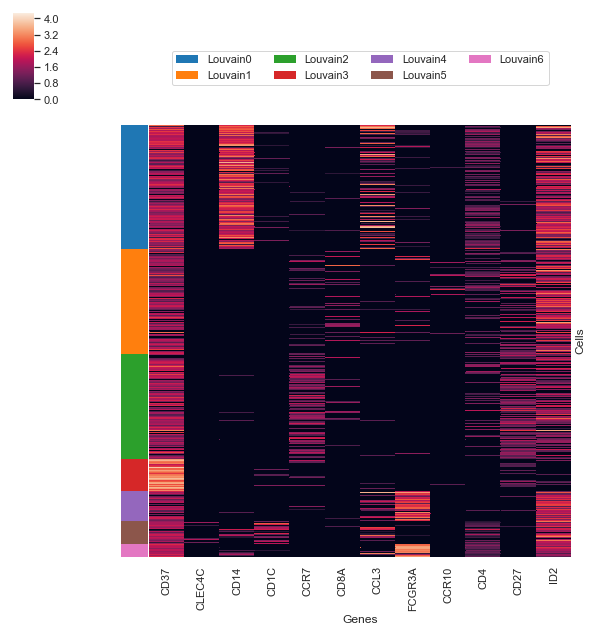

In [64]:
colors = np.array([matplotlib.colors.to_hex(x) for x in cm.tab10.colors])
row_colors = colors[sorted_louvain_groups]

g = sns.clustermap(marker_table, \
                         row_colors=row_colors, \
                         row_cluster=False, \
                         col_cluster=False, \
                         yticklabels=0)

for louvain_label in list(set(louvain_groups)):
    g.ax_col_dendrogram.bar(0, 0, color=colors[louvain_label],
                            label='Louvain'+str(louvain_label), linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=4, facecolor='w')

plt.show()

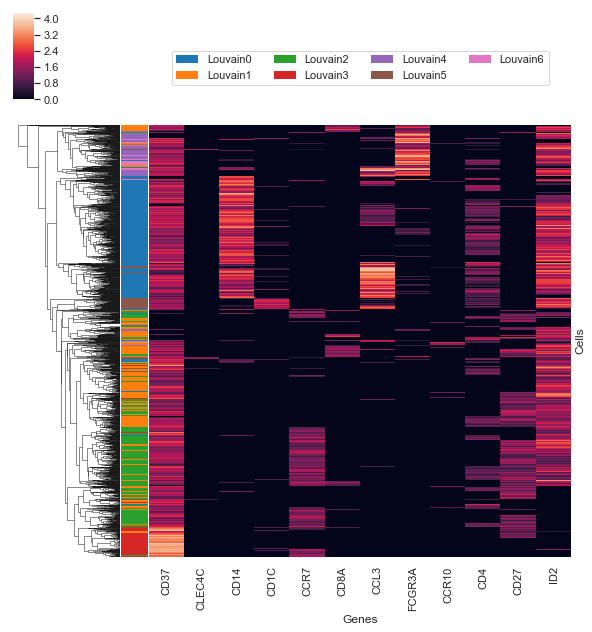

In [65]:
# cellを階層的クラスタリングしてみると、クラスタごとに大体マーカ遺伝子の発現パターンは一致している
g = sns.clustermap(marker_table, \
                         row_colors=row_colors, \
                         row_cluster=True, \
                         col_cluster=False, \
                         yticklabels=0)

for louvain_label in list(set(louvain_groups)):
    g.ax_col_dendrogram.bar(0, 0, color=colors[louvain_label],
                            label='Louvain'+str(louvain_label), linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=4, facecolor='w')

plt.show()

In [66]:
# 注意：きわめて雑で適当なアノテーション。自動的な細胞タイプアノテーションについては
# [論文](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1795-z)などを参照。
louvain_types = {}
for louvain_label in list(set(louvain_groups)):
    diff_others = []
    for g in marker_table.columns:
        cl_mean = marker_table.loc[sorted_louvain_groups == louvain_label, g].values.mean()
        other_mean = marker_table.loc[sorted_louvain_groups != louvain_label, g].values.mean()
        diff_others.append(cl_mean - other_mean)
    top_diff_gene = marker_table.columns[ np.argmax(np.array(diff_others)) ]
    louvain_types[louvain_label] = marker_genes.loc[ marker_genes['Symbol'] == top_diff_gene, 'CellType'].values[0]
print(louvain_types)

{0: 'Macrophage', 1: 'T cell', 2: 'Naive T cell', 3: 'B cell', 4: 'Natural killer cell', 5: 'Monocyte derived dendritic cell', 6: 'Natural killer cell'}


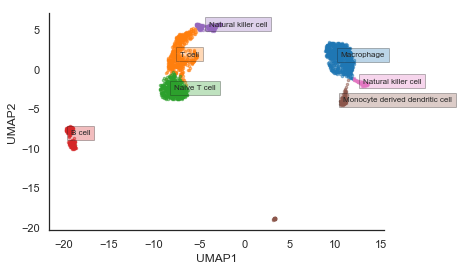

In [67]:
sns.set(style='white')
colors = [matplotlib.colors.to_hex(x) for x in cm.tab10.colors]
fig, ax = plt.subplots()
for cl_id in list(set(louvain_groups)):
    ax.scatter(umap_coords[louvain_groups == cl_id, 0], umap_coords[louvain_groups == cl_id, 1], \
               s=6, alpha=.5, \
               c=colors[cl_id])
    
for cl_id in list(set(louvain_groups)):
    coord_m = np.median(umap_coords[louvain_groups == cl_id, :], axis=0)
    ax.annotate(louvain_types[cl_id], xy=(coord_m), \
              fontsize=8, \
              bbox={"facecolor":colors[cl_id], "edgecolor":"k", "alpha":0.3})
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
sns.despine()
plt.show()